# 0. Configuration

In [1]:
# links to shared data MovieLens
# source on kaggle: https://www.kaggle.com/code/quangnhatbui/movie-recommender/data
MOVIES_METADATA_URL = 'https://drive.google.com/file/d/19g6-apYbZb5D-wRj4L7aYKhxS-fDM4Fb/view?usp=share_link'

# 1. Modules and functions

In [2]:
import re
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from ast import literal_eval
from pymystem3 import Mystem
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import umap.umap_ as umap
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# download stop words beforehand
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kirillgorbunov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1.1. Helper functions to avoid copypaste

In [3]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

In [4]:
# init lemmatizer to avoid slow performance
mystem = Mystem() 

def word_tokenize_clean(doc: str, stop_words: list):
    '''
    tokenize from string to list of words
    '''

    # split into lower case word tokens \w lemmatization
    tokens = list(set(mystem.lemmatize(doc.lower())))
  
    # remove tokens that are not alphabetic (including punctuation) and not a stop word
    tokens = [word for word in tokens if word.isalpha() and not word in stop_words \
              not in list(punctuation)]
    return tokens

# 2. Main

## 2.1. Data Preparation

In [5]:
# read csv information about films etc
movies_metadata = read_csv_from_gdrive(MOVIES_METADATA_URL)
movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [6]:
movies_metadata['tagline'] = movies_metadata.tagline.fillna('')
movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,,Satan Triumphant,False,0.0,0.0


In [7]:
# let's see what columns we have
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

To get accurate results we need to preprocess text a bit. The pipeline will be as follows:

- Filter only necessary columns from movies_metadada : id, original_title, overview;
- Define `model_index` for model to match back with `id` column;
- Text cleaning: removing stopwords & punctuation, lemmatization for further tokenization and tagged document creatin required for gensim.Doc2Vec

In [8]:
# filter cols
sample = movies_metadata[['id', 'original_title', 'overview']].copy()
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              45466 non-null  object
 1   original_title  45466 non-null  object
 2   overview        44512 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [9]:
# as you see from above, we have missing overview in some cases -- let's fill it with the original title
sample.loc[sample['overview'].isnull(), 'overview'] = sample.loc[sample['overview'].isnull(), 'original_title']
sample.isnull().sum()

id                0
original_title    0
overview          0
dtype: int64

In [10]:
# define model_index and make it as string
sample = sample.reset_index().rename(columns = {'index': 'model_index'})
sample['model_index'] = sample['model_index'].astype(str)

In [11]:
# create mapper with title and model_idnex to use it further in evaluation
movies_inv_mapper = dict(zip(sample['original_title'].str.lower(), sample['model_index'].astype(int)))

In [12]:
# preprocess by removing non-character data, stopwords
tags_corpus = sample['overview'].values
tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
stop_words = stopwords.words('english')

tags_doc = [word_tokenize_clean(description, stop_words) for description in tags_corpus]
tags_corpus[:1]

["Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."]

In [13]:
# prepare data as model input for Word2Vec
## it takes some time to execute
tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

In [14]:
# let's check what do we have
## tag = movie index
tags_doc[1]

TaggedDocument(words=['risky', 'trapped', 'three', 'enchanted', 'terrifying', 'magical', 'inside', 'world', 'judy', 'unwittingly', 'running', 'living', 'giant', 'board', 'game', 'monkeys', 'door', 'alan', 'adult', 'siblings', 'proves', 'peter', 'find', 'rhinoceroses', 'opens', 'room', 'years', 'freedom', 'discover', 'finish', 'creatures', 'evil', 'invite', 'hope'], tags=['1'])

# 2.2. Model Training and Evaluation

In [15]:
VEC_SIZE = 50
ALPHA = .02
MIN_ALPHA = .00025
MIN_COUNT = 5
EPOCHS = 20

In [16]:
# initialize
model = Doc2Vec(vector_size = VEC_SIZE,
                alpha = ALPHA, 
                min_alpha = MIN_ALPHA,
                min_count = MIN_COUNT,
                dm = 0)

In [17]:
# generate vocab from all tag docs
model.build_vocab(tags_doc)

In [18]:
# train model
model.train(tags_doc,
            total_examples = model.corpus_count,
            epochs = EPOCHS)

## 2.3. Evaluate the model

Let's assume that we watched movie `batman` and based on that generate recommendation similar to it's description.

To do that we need
- To extract movie id from `movies_inv_mapper` we created to map back titles from model output
- Load embeddings from trained model
- Use built-in most_similar() method to get most relevant recommendations based on film embedding
- Finally, map title names for sense-check

In [19]:
# get id
movie_id = movies_inv_mapper['batman']
movie_id

8603

In [20]:
# load trained embeddings 
movies_vectors = model.dv.vectors

In [21]:
movie_embeddings = movies_vectors[movie_id]

In [22]:
# get recommendations
similars = model.docvecs.most_similar(positive = [movie_embeddings], topn = 20)
output = pd.DataFrame(similars, columns = ['model_index', 'model_score'])
output.head()

,model_index,model_score
0,8603,1.000000
1,5713,0.964204
2,13835,0.956272
3,7772,0.952336
4,28854,0.951784


In [23]:
# reverse values and indices to map names in dataframe
name_mapper = {v: k for k, v in movies_inv_mapper.items()}

In [24]:
output['title_name'] = output['model_index'].astype(int).map(name_mapper)
output


,model_index,model_score,title_name
0,8603,1.000000,batman
1,5713,0.964204,rollover
2,13835,0.956272,k2
3,7772,0.952336,this island earth
4,28854,0.951784,lunar cop
5,43461,0.950673,megafault
6,1045,0.949848,sleeper
7,8916,0.948193,killer klowns from outer space
8,24433,0.945968,the creeping terror
9,25184,0.945027,penguins of madagascar


4.Create a visualisation for sample with one column of tags

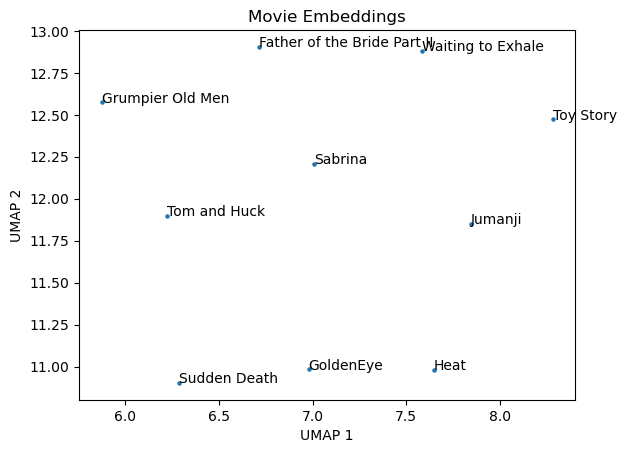

In [25]:
movie_embeddings = movies_vectors[:10]

umap_reducer = umap.UMAP()
movie_embeddings_2d = umap_reducer.fit_transform(movie_embeddings)

movie_titles = movies_metadata['original_title'].values

movie_titles = movie_titles[:10]

plt.scatter(movie_embeddings_2d[:, 0], movie_embeddings_2d[:, 1], s=5)

for i, title in enumerate(movie_titles):
    plt.annotate(title, (movie_embeddings_2d[i, 0], movie_embeddings_2d[i, 1]))

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Movie Embeddings')
plt.show()

# TODO

- Add `original_title`, `keywords`, `tagline` and other metadata to train sample and then retrain embeddings;
- Make visualization of embeddings with links of films with each other;
- Compare results with the embeddings we created in lecture
- Write function get_recommendations() which takes arguments we used 2.3., but such that we can use embeddings of several watched films to get recommendations

# Appendix

Here, we wrap up all pipeline into functions to re-use if needed and it is just prettier to code this way :)

In [26]:
def get_clean_tags_array(agg_tags: pd.DataFrame,
                         text_col = 'tag'):
    '''text preprocessing
    '''
    tags_corpus = agg_tags[text_col].values
    tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
    stop_words = stopwords.words('english')


    # preprocess corpus of movie tags before feeding it into Doc2Vec model
    tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

    return tags_doc


In [27]:
def train_embeddings(tags_doc: np.array,
                     epochs = 20,
                     vec_size = 50,
                     alpha = .02,
                     min_alpha =  0.00025,
                     min_count = 5,
                     save_path: str = None):
    """
    fit doc2vec model to prepared corpus
    :tags_doc: result of get_clean_tags_array()
    :max_epocs: int
    :vec_size: int
    :alpha: float
    """
    #initialize
    model = Doc2Vec(vector_size = vec_size,
                    alpha = alpha, 
                    min_alpha = min_alpha,
                    min_count = min_count,
                    dm = 0)
    
    #generate vocab from all tag docs
    model.build_vocab(tags_doc)
    
    #train model
    model.train(tags_doc,
                total_examples = model.corpus_count,
                epochs = epochs)
    
    #save model to dir
    if save_path:
        model.save(f'{save_path}/d2v_model.pkl')
    
    return model

1. Create a df with several rows to build tags on



In [28]:
#define new sample and precrocess
sample = movies_metadata[['id', 'original_title', 'overview','tagline']].copy()
sample.loc[sample['overview'].isnull(), 'overview'] = sample.loc[sample['overview'].isnull(), 'original_title']
sample = sample.reset_index().rename(columns = {'index': 'model_index'})
sample['model_index'] = sample['model_index'].astype(str)
movies_inv_mapper = dict(zip(sample['original_title'].str.lower(), sample['model_index'].astype(int)))

In [29]:
#create tags for new sample
tags_corpus = (sample['overview'].values + ' ' + sample['original_title'].values+ ' ' + sample['tagline'].values)
tags_corpus = [re.sub('-[!/()0-9]', '', x) for x in tags_corpus]
stop_words = stopwords.words('english')

tags_doc = [word_tokenize_clean(description, stop_words) for description in tags_corpus]
tags_doc[:1]

[['losing',
  'separate',
  'circumstances',
  'onto',
  'aside',
  'afraid',
  'heart',
  'led',
  'birthday',
  'andy',
  'brings',
  'duo',
  'toys',
  'learns',
  'buzz',
  'lightyear',
  'put',
  'live',
  'woody',
  'story',
  'scene',
  'room',
  'owner',
  'eventually',
  'happily',
  'toy',
  'place',
  'differences',
  'plots']]

In [30]:
# prepare data as model input for Word2Vec
tags_doc = [TaggedDocument(words = word_tokenize_clean(D, stop_words), tags = [str(i)]) for i, D in enumerate(tags_corpus)]

In [31]:
#creating model
model = train_embeddings(tags_doc)

In [32]:
#gettting movie_id
movie_id = movies_inv_mapper['batman']
movie_id

8603

In [33]:
#gettin all movie vectors
movies_vectors = model.dv.vectors

In [34]:
#getting the embedings for batman
movie_embeddings = movies_vectors[movie_id]

In [35]:
# getting recs for batman
similars = model.docvecs.most_similar(positive = [movie_embeddings], topn = 20)
output = pd.DataFrame(similars, columns = ['model_index', 'model_score'])
output.head()

,model_index,model_score
0,8603,1.000000
1,35181,0.926492
2,43461,0.925205
3,20304,0.922369
4,21688,0.921844


2.Create a visualisation for sample with several columns of tags

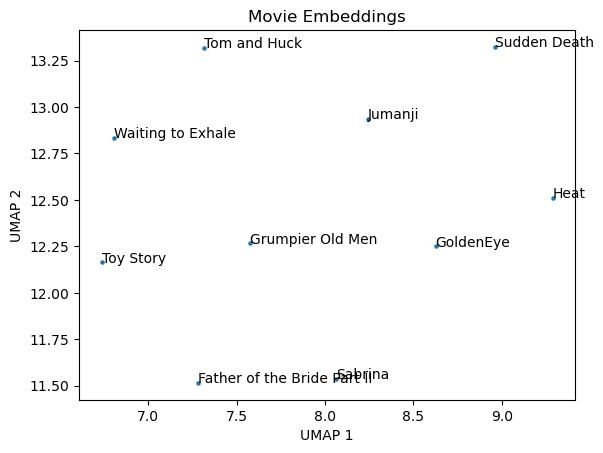

In [36]:
#define movieemoedigs and limit to 10
movie_embeddings = movies_vectors[:10]

#define and fit umanp
umap_reducer = umap.UMAP()
movie_embeddings_2d = umap_reducer.fit_transform(movie_embeddings)

#define titles
movie_titles = movies_metadata['original_title'].values

#limit titles to 10
movie_titles = movie_titles[:10]

#crate a scatterplot for umap
plt.scatter(movie_embeddings_2d[:, 0], movie_embeddings_2d[:, 1], s=5)

#name the embeddings by movie titles
for i, title in enumerate(movie_titles):
    plt.annotate(title, (movie_embeddings_2d[i, 0], movie_embeddings_2d[i, 1]))

#define names of axes and graph
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Movie Embeddings')
plt.show()

4. Define get_recommendations() 

In [37]:
def get_recommendations(movies_list: list):
    """
    creates a data frame of recomendations for several films
    :movies_list: a list of movies to find recomendations for
    """
    #initialaize an empty list for vectors
    d = []
    
    #cycle for creating embeddings for each movie
    for x in movies_list:
        result = movies_inv_mapper[x]
        d.append(result)
    me= movies_vectors[d]
    
    #initialize empty lists for results
    u=[]
    o=[]
    
    #cycles to create output
    for x in range(len(me)):
        result = model.docvecs.most_similar(positive = [me[x]], topn = 25)
        u.append(result)
    for i in range(len(u)):
        output = pd.DataFrame(u[i], columns = ['model_index', 'model_score'])
        o.append(output)
    
    #process df for output
    df = pd.concat(o)
    df = df.sort_values(by=['model_score'],ascending=False)
    df = df[df.model_score < 1]
    df = df.head(20)
    
    return df

In [38]:
#check
x =get_recommendations(('batman','jumanji','superman'))
x

,model_index,model_score
0,2,1.000000
1,24187,0.956135
2,16363,0.949099
3,42845,0.947376
4,14476,0.946747
5,20375,0.946628
6,249,0.943491
7,29382,0.943219
8,19874,0.942098
9,14989,0.940811


5.Creating Another version of get_recomendations function

In [39]:
def get_recommendations_multivector(movies_list: list):
    #initialize empty list for vectors of movies
    d = []
    #cycle for creating embeddings for each movie
    for x in movies_list:
        result = movies_inv_mapper[x]
        d.append(result)
    me= movies_vectors[d]
    
    #get recomendations for movies
    result = model.docvecs.most_similar(positive = me, topn = 20)
    output = pd.DataFrame(result, columns = ['model_index', 'model_score'])
    return output

In [40]:
#check
s = get_recommendations_multivector(('batman','jumanji','superman'))
s

,model_index,model_score
0,43461,0.960042
1,40116,0.959913
2,32982,0.958388
3,42042,0.957285
4,41165,0.955201
5,19148,0.954189
6,34515,0.952988
7,16095,0.952165
8,32731,0.952105
9,37342,0.951858
